In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

In [26]:
df_amazon=pd.read_csv('./data_cleaned/tw amazon.csv')
df_walmart=pd.read_csv('./data_cleaned/tw walmart.csv')
df_target=pd.read_csv('./data_cleaned/tw target.csv')
df_eBay=pd.read_csv('./data_cleaned/tw eBay.csv')
df_Bestbuy=pd.read_csv('./data_cleaned/tw Bestbuy.csv')

In [27]:
# create new column platform to remember which platform it is 
df_amazon['platform']=['amazon']*(len(df_amazon))
df_walmart['platform']=['walmart']*(len(df_walmart))
df_target['platform']=['target']*(len(df_target))
df_eBay['platform']=['eBay']*(len(df_eBay))
df_Bestbuy['platform']=['Bestbuy']*(len(df_Bestbuy))

In [28]:
# merge the data frame to create a new data frame.
df_all=df_walmart.merge(df_amazon,how='outer').merge(df_target,how='outer').merge(df_eBay,how='outer').merge(df_Bestbuy,how='outer')
df_all.head()

,source,lang,edit_history_tweet_ids,created_at,text,id,author_id,public_metrics,cleaned_text,Tweet_tokenized,platform
0,Twitter for Android,en,['1578844547748020224'],2022-10-08T20:27:28.000Z,RT @TalbertSwan: The Black delegation will tra...,1578844547748020224,46243705,"{'retweet_count': 3597, 'reply_count': 0, 'lik...",TalbertSwan Black delegation will trade Kanye ...,"['talbertswan', 'black', 'delegation', 'will',...",walmart
1,Twitter for Android,en,['1578844547236646913'],2022-10-08T20:27:28.000Z,I wanna be old and grey and still get random k...,1578844547236646913,1311130506243854338,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",wanna grey still random kisses line Walmart,"['wanna', 'grey', 'still', 'random', 'kisses',...",walmart
2,Twitter for iPhone,en,['1578844542983249923'],2022-10-08T20:27:27.000Z,"Don’t ask me why, but Walmart = wear a mask. I...",1578844542983249923,906190737829576704,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Dont Walmart wear mask rules,"['dont', 'walmart', 'wear', 'mask', 'rules']",walmart
3,Twitter for iPhone,en,['1578844536847335425'],2022-10-08T20:27:25.000Z,@NedJeffers You’re most welcome. \n\nBtw if yo...,1578844536847335425,1416609128,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NedJeffers Youre most welcome have trouble hol...,"['nedjeffers', 'youre', 'most', 'welcome', 'ha...",walmart
4,Twitter Web App,en,['1578844499869982720'],2022-10-08T20:27:16.000Z,RT @OfficerPorkChop: @LauraLynn209 Meanwhile h...,1578844499869982720,1449191119867326464,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",OfficerPorkChop LauraLynn209 Meanwhile walking...,"['officerporkchop', 'lauralynn209', 'meanwhile...",walmart


In [29]:
# create a copy of dataframe with drop the rows that a useless.
df_all_copy=df_all.drop(['public_metrics','edit_history_tweet_ids','id','created_at','author_id','text','cleaned_text','source','lang'],axis=1)
df_all_copy.head()

,Tweet_tokenized,platform
0,"['talbertswan', 'black', 'delegation', 'will',...",walmart
1,"['wanna', 'grey', 'still', 'random', 'kisses',...",walmart
2,"['dont', 'walmart', 'wear', 'mask', 'rules']",walmart
3,"['nedjeffers', 'youre', 'most', 'welcome', 'ha...",walmart
4,"['officerporkchop', 'lauralynn209', 'meanwhile...",walmart


In [30]:
final_lines=[i.replace(",","").replace("[","").replace("]","").replace("'","") for i in df_all_copy['Tweet_tokenized']]
final_lines[0:5]

['talbertswan black delegation will trade kanye west herschel walker walmart gift card',
 'wanna grey still random kisses line walmart',
 'dont walmart wear mask rules',
 'nedjeffers youre most welcome have trouble holding things also recommend this httpstcortzhkjduzb helped huge amount formative years',
 'officerporkchop lauralynn209 meanwhile walking through walmart with mistress next']

In [31]:
df_all_copy['final_lines']=final_lines

In [32]:
df_all_copy=df_all_copy.drop('Tweet_tokenized',axis=1)

In [33]:
df_all_copy['platform'].value_counts()

walmart    100
amazon     100
eBay       100
Bestbuy    100
target      91
Name: platform, dtype: int64

In [34]:
# set x and y
X=df_all_copy['final_lines'].values
y=df_all_copy['platform'].values

In [35]:
# convert y to the format that use different integer te represent different choice
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [36]:
# check the object.
labelencoder.classes_

array(['Bestbuy', 'amazon', 'eBay', 'target', 'walmart'], dtype=object)

In [37]:
# separate the train and test set with 0.7 and 0.3.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [38]:
# check the shape
print(X_train.shape)
print(y_test.shape)

(343,)
(148,)


#### Decision Tree Type1

In [39]:
# Convert test data to numbers using countvectorizer and TfidfVectorizer
# We shall compare results from both based on the decision tree accuracy and Confusion Matrix.
# Use countvectorizer
vectorizer = CountVectorizer()
X_train1 = vectorizer.fit_transform(X_train.astype('U')) #converts dtype object in text data to a unicode string to avoid np.nan error. 
X_test1 = vectorizer.transform(X_test.astype('U'))

In [40]:
# check the accuracy first.
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train1, y_train)
y_pred = dt.predict(X_test1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# We see that the accuracy is 0.89

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.71      1.00      0.83        35
           2       1.00      0.81      0.89        36
           3       0.94      0.68      0.79        22
           4       0.97      0.97      0.97        29

    accuracy                           0.89       148
   macro avg       0.92      0.88      0.89       148
weighted avg       0.92      0.89      0.89       148

[[25  0  0  1  0]
 [ 0 35  0  0  0]
 [ 0  7 29  0  0]
 [ 0  6  0 15  1]
 [ 0  1  0  0 28]]


<AxesSubplot: >

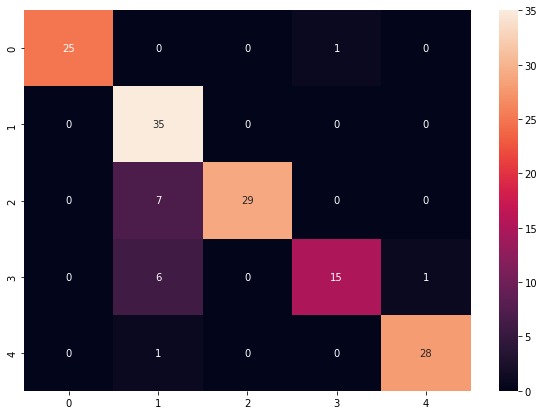

In [49]:
# plot a heat map to visualize.
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

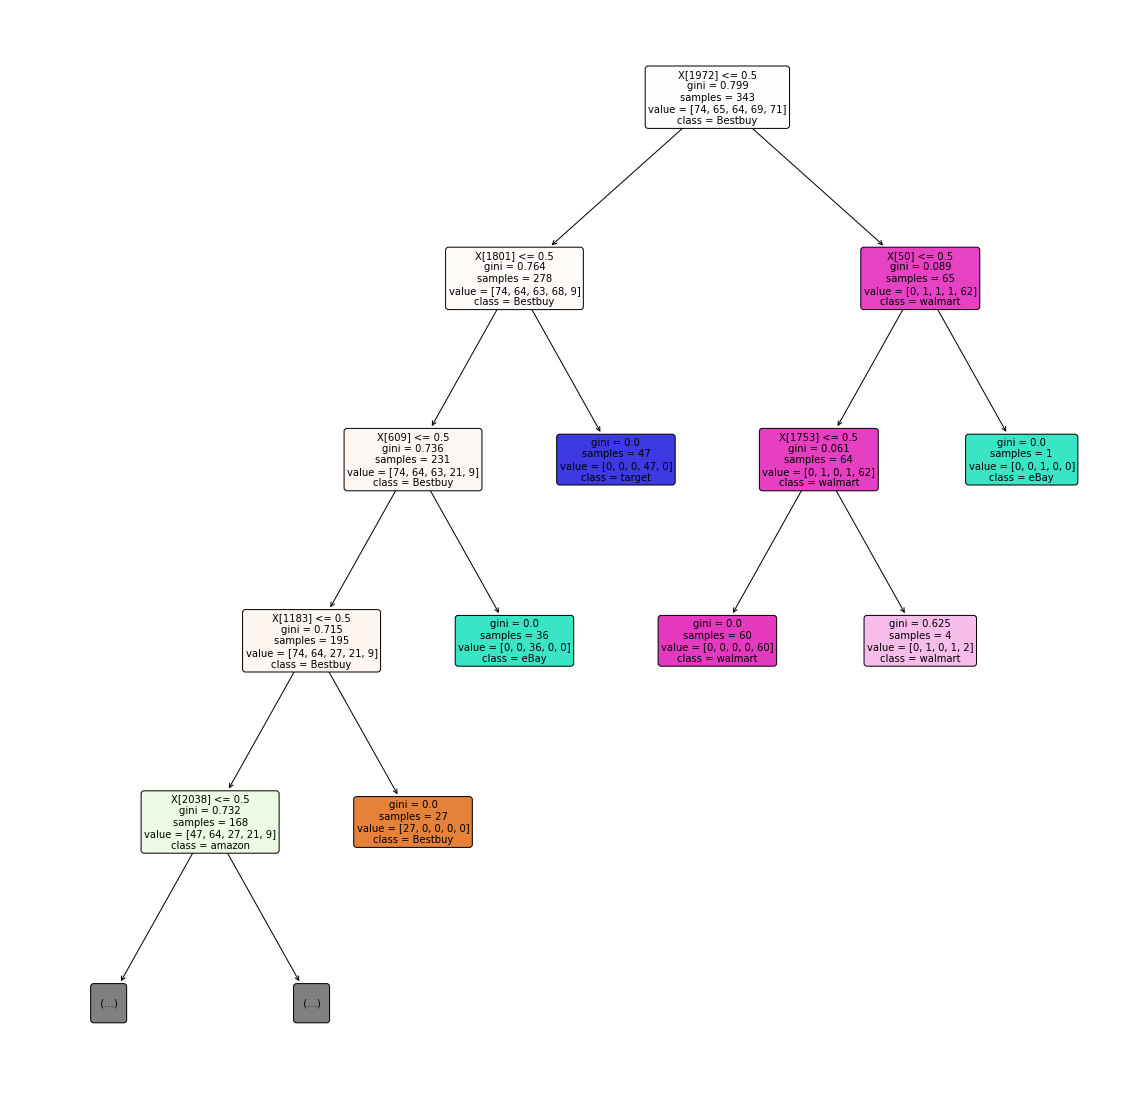

In [61]:
# Visualising the graph without the use of graphviz
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dt,class_names=['Bestbuy', 'amazon', 'eBay', 'target', 'walmart'],filled=True, rounded=True, fontsize=10, max_depth=4)

In [54]:
# using TfidfVectorizer
vectorizer1 = TfidfVectorizer()
X_train2 = vectorizer1.fit_transform(X_train.astype('U')) #converts dtype object in text data to a unicode string to avoid np.nan error. 
X_test2 = vectorizer1.transform(X_test.astype('U'))

In [55]:
dt2 = DecisionTreeClassifier(random_state=42)
dt2.fit(X_train2, y_train)
y_pred2 = dt.predict(X_test2)
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
# The accuracy is 0.39 which is quite low.

              precision    recall  f1-score   support

           0       1.00      0.31      0.47        26
           1       0.28      1.00      0.43        35
           2       1.00      0.31      0.47        36
           3       1.00      0.14      0.24        22
           4       0.00      0.00      0.00        29

    accuracy                           0.39       148
   macro avg       0.66      0.35      0.32       148
weighted avg       0.63      0.39      0.34       148

[[ 8 18  0  0  0]
 [ 0 35  0  0  0]
 [ 0 25 11  0  0]
 [ 0 19  0  3  0]
 [ 0 29  0  0  0]]


c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

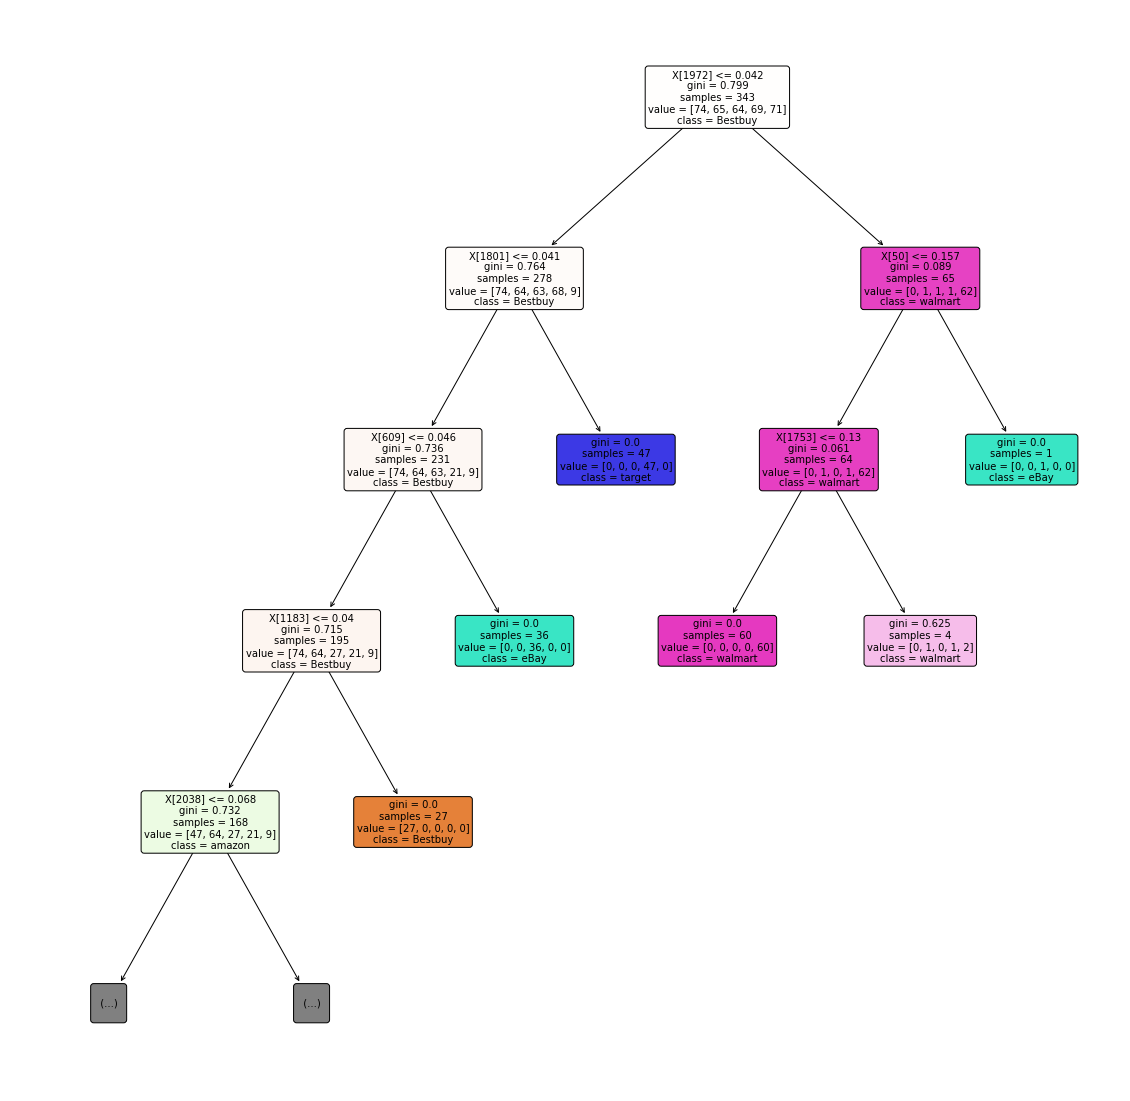

In [62]:
# Visualising the graph without the use of graphviz
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dt2,class_names=['Bestbuy', 'amazon', 'eBay', 'target', 'walmart'],filled=True, rounded=True, fontsize=10, max_depth=4)

In [ ]:
# since the accuracy of CountVectorize is much more higher than the TfidfVectorize, we shall choose to use CountVecotorize

#### Decision Tree Type 2

In [58]:
# Using splitter='best' for Decision Tree
# The strategy that use to choose the split at each node. Supported strategies are "best" to choose the best split and "random" to choose the best random split.
dt_1 = DecisionTreeClassifier(splitter='best')
dt_1.fit(X_train1, y_train)
y_pred = dt_1.predict(X_test1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.71      1.00      0.83        35
           2       0.97      0.81      0.88        36
           3       1.00      0.68      0.81        22
           4       0.97      0.97      0.97        29

    accuracy                           0.89       148
   macro avg       0.93      0.88      0.89       148
weighted avg       0.92      0.89      0.89       148

[[25  0  1  0  0]
 [ 0 35  0  0  0]
 [ 0  7 29  0  0]
 [ 0  6  0 15  1]
 [ 0  1  0  0 28]]


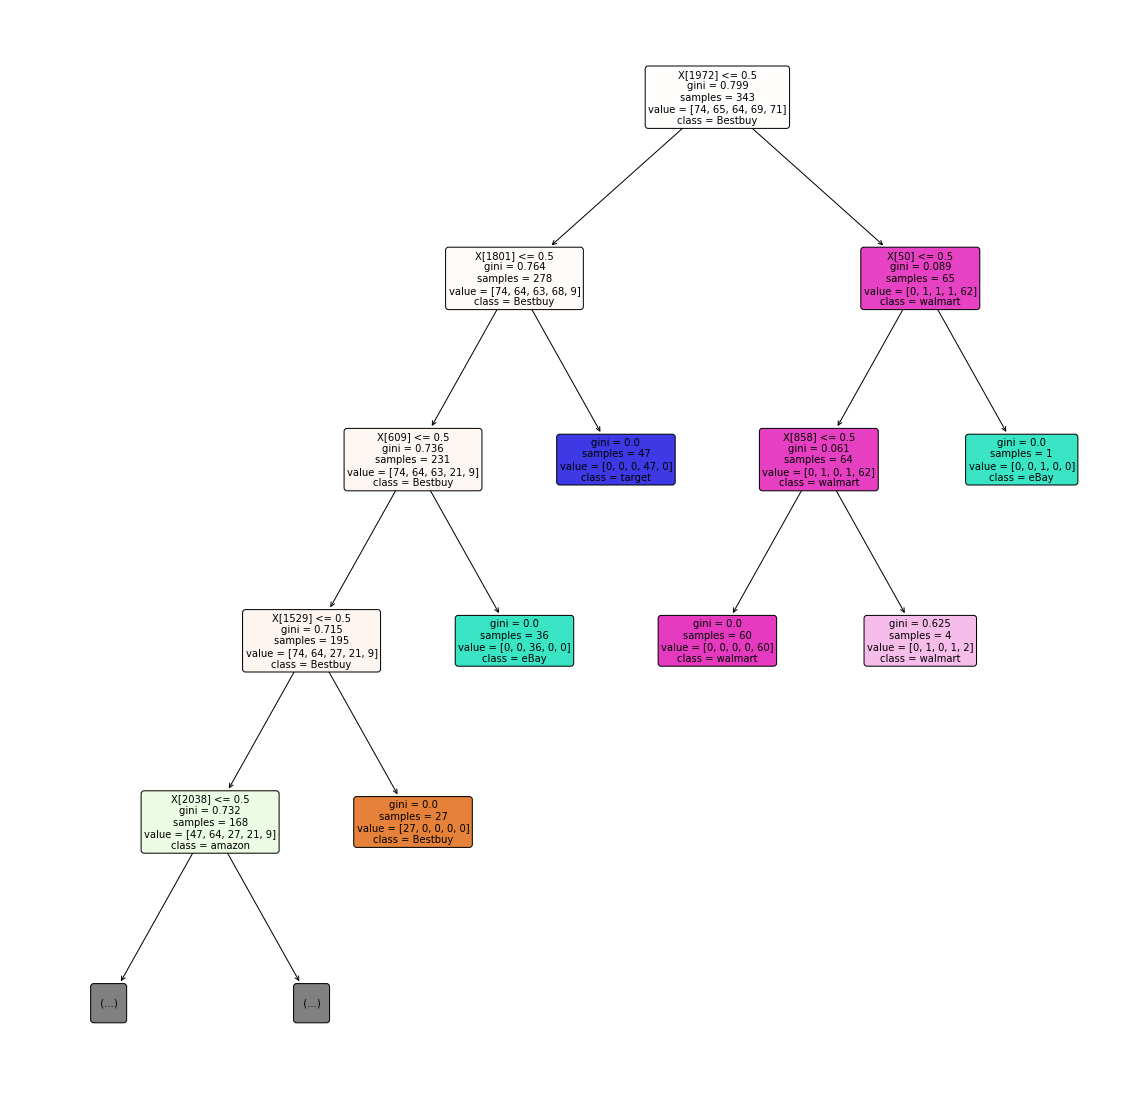

In [63]:
# Visualising the graph without the use of graphviz
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dt_1,class_names=['Bestbuy', 'amazon', 'eBay', 'target', 'walmart'],filled=True, rounded=True, fontsize=10, max_depth=4)

#### Decision Tree Type 3
using K cross fold validation with k=3

In [67]:
# define a function to print the accuracy for both training and testing data set.
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train1)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test1)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random")
}


tree_clf = DecisionTreeClassifier(random_state=42)

tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3) 
#n_jobs= Number of jobs to run in parallel. None means 1 unless in a joblib. parallel_backend context. -1 means using all processors
#cv= splits the data into 3 parts. first two are used for training and the third one is used for testing. 
tree_cv.fit(X_train1, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train1, y_train)
print_score(tree_clf, X_train1, y_train, X_test1, y_test, train=True)
print_score(tree_clf, X_train1, y_train, X_test1, y_test, train=False)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best paramters: {'criterion': 'entropy', 'splitter': 'random'})
Train Result:
Accuracy Score: 99.42%
_______________________________________________
CLASSIFICATION REPORT:
              0          1     2          3          4  accuracy   macro avg  \
precision   1.0   1.000000   1.0   1.000000   0.972603  0.994169    0.994521   
recall      1.0   0.984615   1.0   0.985507   1.000000  0.994169    0.994025   
f1-score    1.0   0.992248   1.0   0.992701   0.986111  0.994169    0.994212   
support    74.0  65.000000  64.0  69.000000  71.000000  0.994169  343.000000   

           weighted avg  
precision      0.994329  
recall         0.994169  
f1-score       0.994188  
support      343.000000  
_______________________________________________
Confusion Matrix: 
 [[74  0  0  0  0]
 [ 0 64  0  0  1]
 [ 0  0 64  0  0]
 [ 0  0  0 68  1]
 [ 0  0  0  0 71]]

Test Result:
Accuracy Score: 90.54%
_________________________________________

In [69]:
import sys
sys.setrecursionlimit(5000)

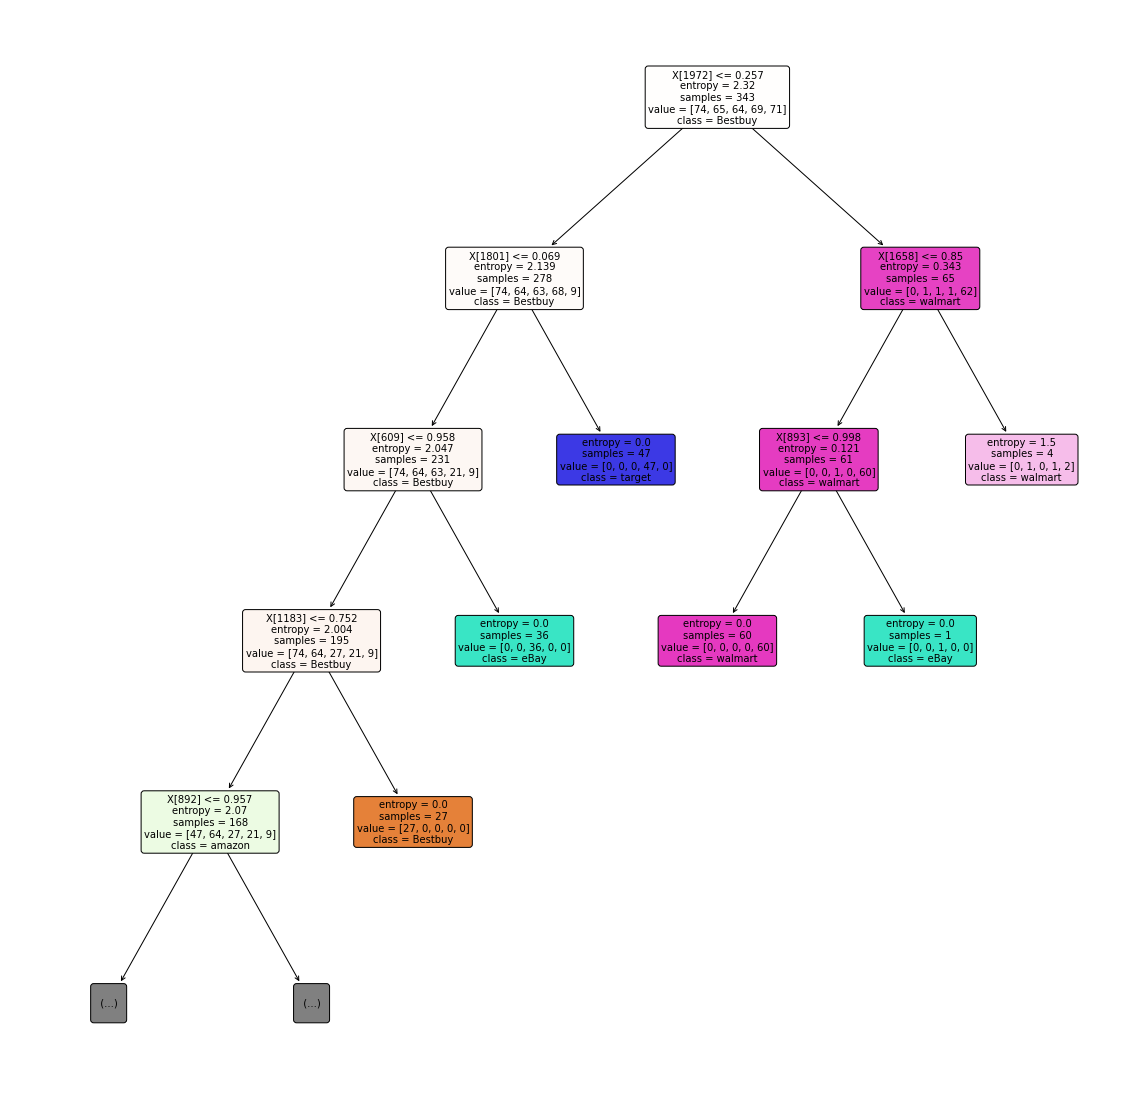

In [70]:
# Visualising the graph without the use of graphviz
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=tree_clf,class_names=['Bestbuy', 'amazon', 'eBay', 'target', 'walmart'],filled=True, rounded=True, fontsize=10, max_depth=4)

In [ ]:
########################################################
########################################################
# since hw only need us to use the text data or record data. 
# After explaining all the situation above, 
# I will only discuss about one of the results below in my Discussion Tree html, and all the other tree graphs are the extra graphs that I plot.
########################################################
########################################################

In [2]:
# second Decision Tree to test for whether a consumer will choose to buy certain product.
df2=pd.read_csv('./data/online_shoppers_intention.csv')
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# select the column
df2_use=df2[["BounceRates","ExitRates","PageValues","ProductRelated_Duration"]]
df2_use.head()

,BounceRates,ExitRates,PageValues,ProductRelated_Duration
0,0.20,0.20,0.0,0.000000
1,0.00,0.10,0.0,64.000000
2,0.20,0.20,0.0,0.000000
3,0.05,0.14,0.0,2.666667
4,0.02,0.05,0.0,627.500000


In [4]:
df2_use=df2_use.head(1000)

In [5]:
for i in range(len(df2_use['PageValues'])):
    if df2_use['PageValues'][i]>0:
        df2_use['PageValues'][i]=1
    else:
        df2_use['PageValues'][i]=0

In [6]:
X=df2_use[["BounceRates","ExitRates","ProductRelated_Duration"]]
y=df2_use['PageValues']

In [7]:
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)
text_representation = tree.export_text(clf)

In [ ]:
# print(text_representation)

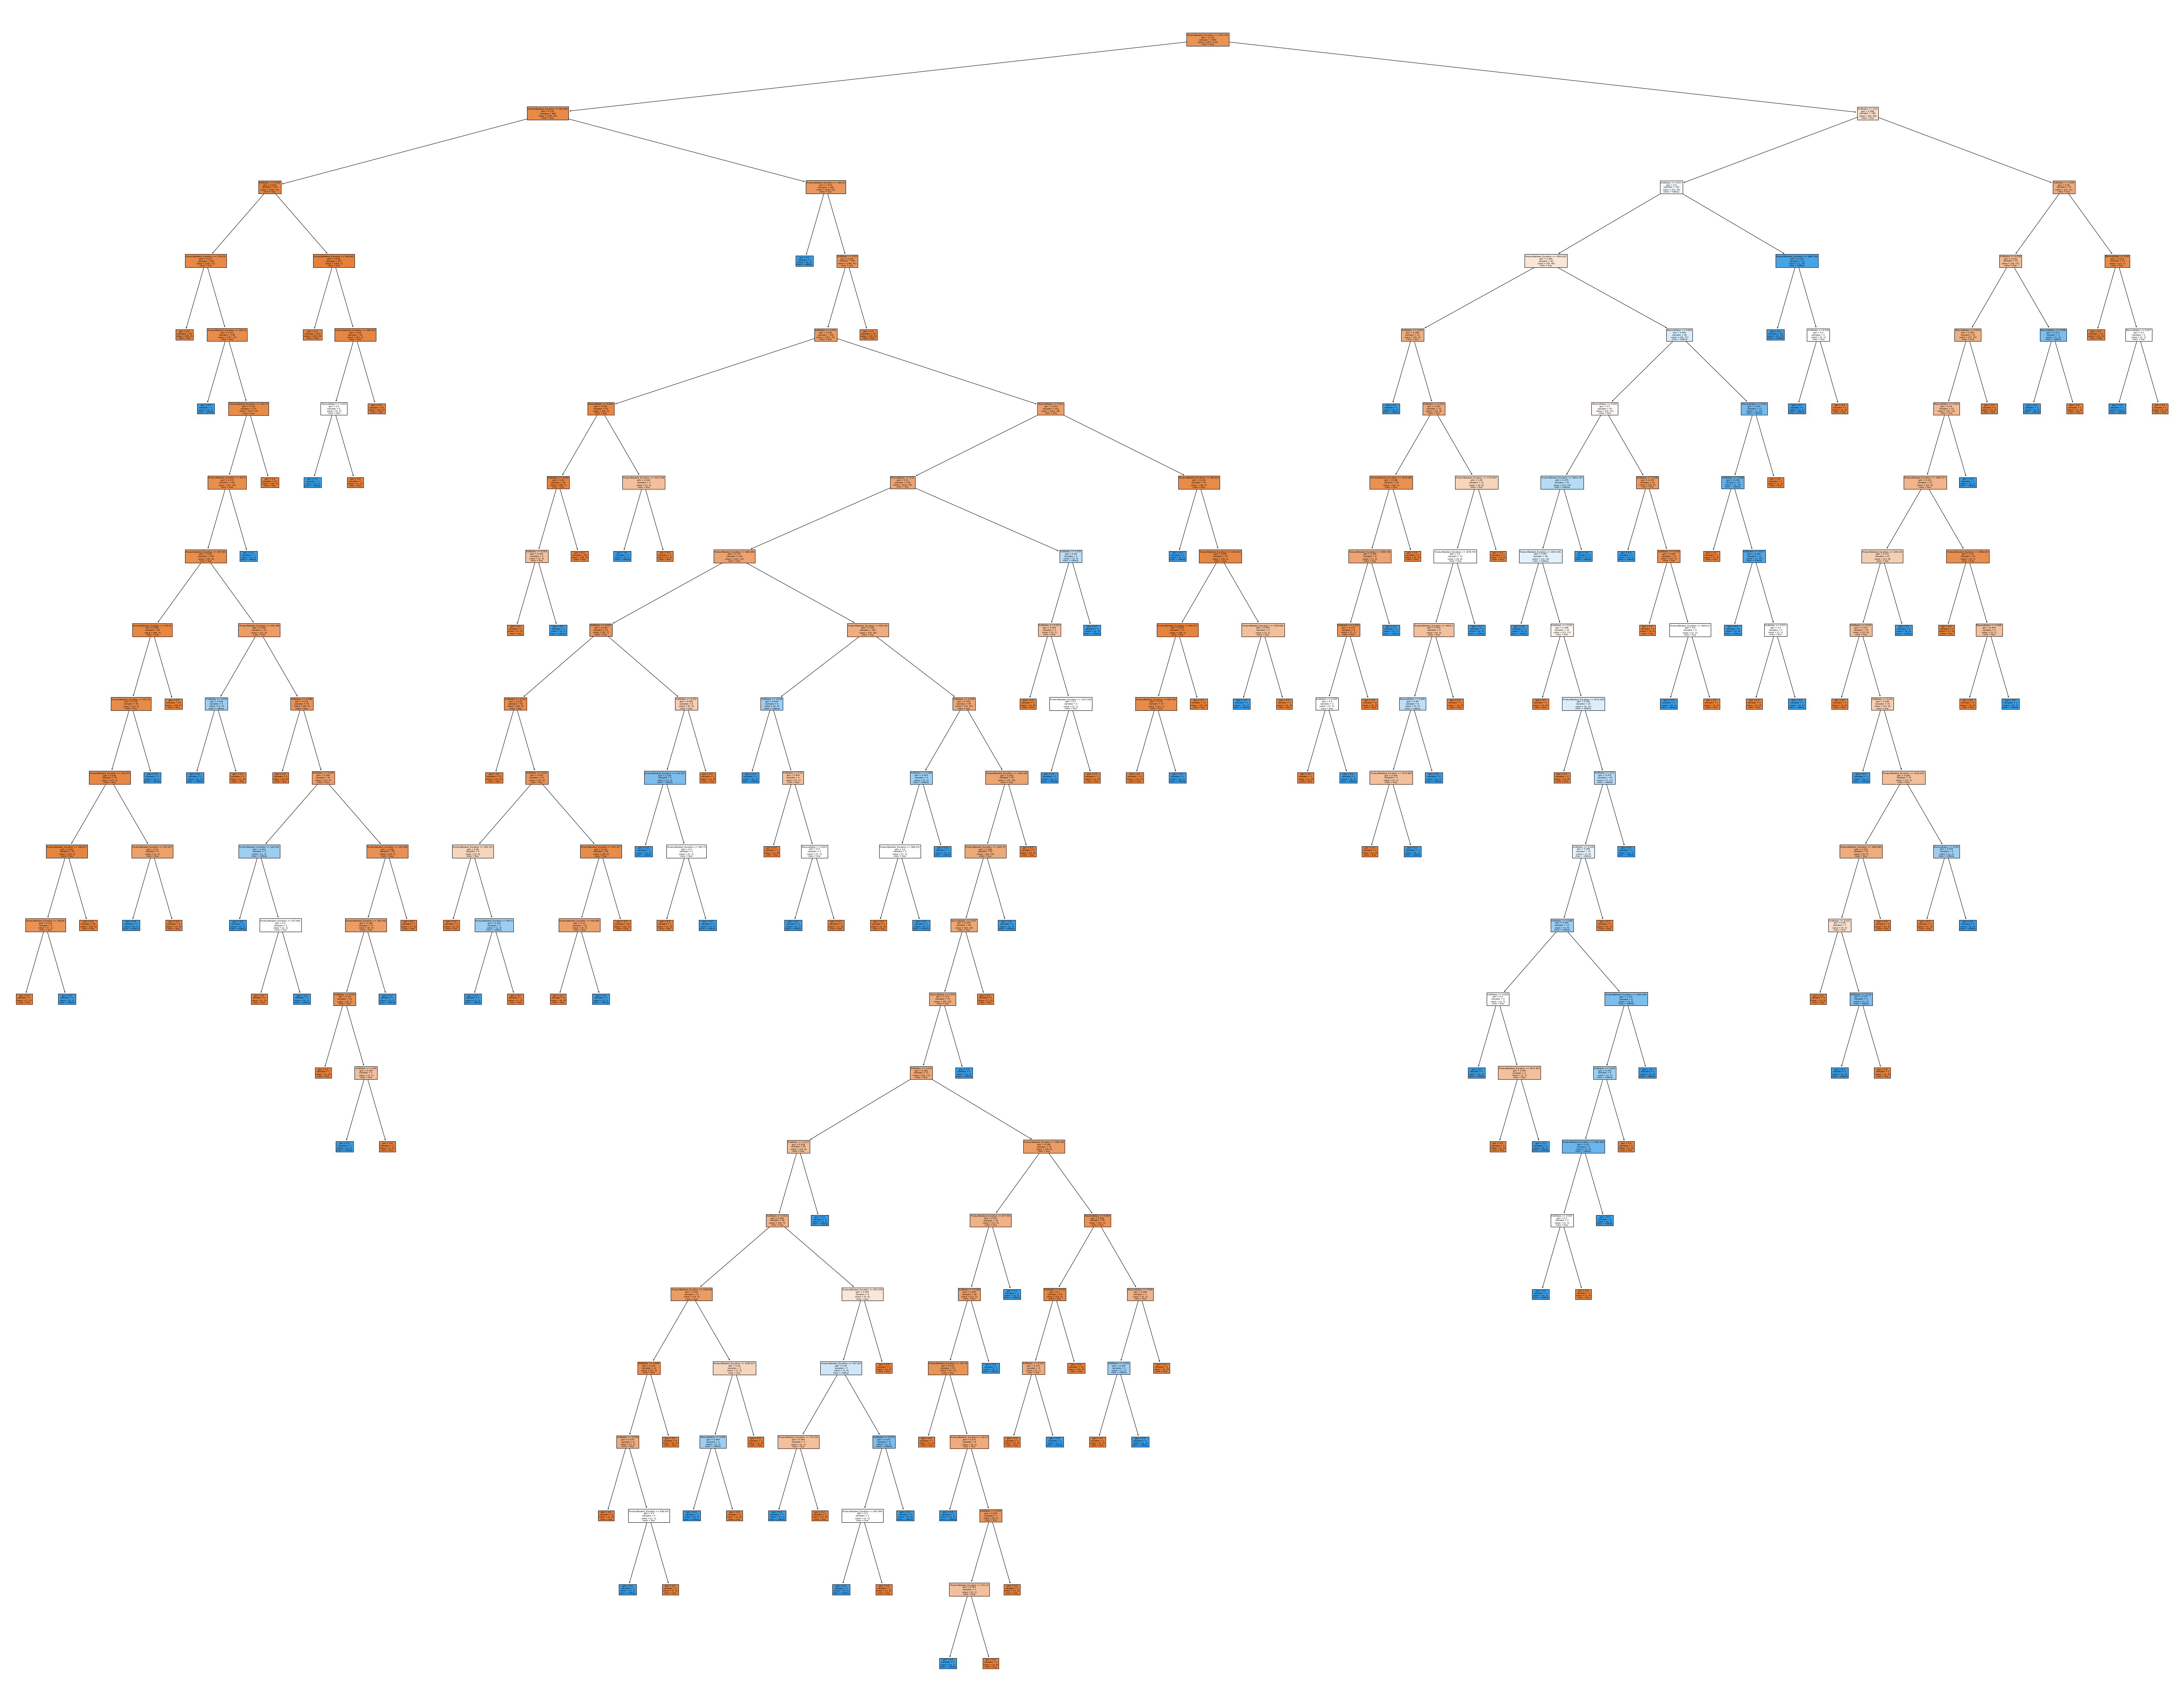

In [26]:
fig = plt.figure(figsize=(100,80))
A = tree.plot_tree(clf, 
                   feature_names=["BounceRates","ExitRates","ProductRelated_Duration"],  
                   class_names=['buy','notbuy'],
                   filled=True)

In [ ]:
# The tree is so complicated, so I will not use decision tree to analyze this data.

In [ ]:
##########################################
#### Make a discision about whether the yearly spent of a consumer is high or middle or low
############################################

In [2]:
df3=pd.read_csv('./data/35.csv')
df3.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [3]:
df3.columns

Index(['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership', 'Yearly Amount Spent'],
      dtype='object')

In [4]:
df3_use=df3[['Avg. Session Length', 'Time on App','Time on Website', 'Yearly Amount Spent', 'Length of Membership']]
df3_use.head()

,Avg. Session Length,Time on App,Time on Website,Yearly Amount Spent,Length of Membership
0,34.497268,12.655651,39.577668,587.951054,4.082621
1,31.926272,11.109461,37.268959,392.204933,2.664034
2,33.000915,11.330278,37.110597,487.547505,4.104543
3,34.305557,13.717514,36.721283,581.852344,3.120179
4,33.330673,12.795189,37.536653,599.406092,4.446308


In [5]:
df3_use['Yearly Spent']=['']*len(df3_use)

C:\Users\84160\AppData\Local\Temp\ipykernel_9536\2544276676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_use['Yearly Spent']=['']*len(df3_use)


In [6]:
# for i in range(len(df3_use['Yearly Amount Spent'])):
#     if df3_use['Yearly Amount Spent'][i]<400:
#         df3_use['Yearly Spent'][i]='v_low'
#     elif df3_use['Yearly Amount Spent'][i]>=400 and df3_use['Yearly Amount Spent'][i]<460:
#         df3_use['Yearly Spent'][i]='low'
#     elif df3_use['Yearly Amount Spent'][i]>=460 and df3_use['Yearly Amount Spent'][i]<560:
#         df3_use['Yearly Spent'][i]='middle'
#     elif df3_use['Yearly Amount Spent'][i]>=560 and df3_use['Yearly Amount Spent'][i]<610:
#         df3_use['Yearly Spent'][i]='high'
#     elif df3_use['Yearly Amount Spent'][i]>=610:
#         df3_use['Yearly Spent'][i]='v_high'


for i in range(len(df3_use['Yearly Amount Spent'])):
    if df3_use['Yearly Amount Spent'][i]<450:
        df3_use['Yearly Spent'][i]='low'
    elif df3_use['Yearly Amount Spent'][i]>=450 and df3_use['Yearly Amount Spent'][i]<570:
        df3_use['Yearly Spent'][i]='middle'
    elif df3_use['Yearly Amount Spent'][i]>=570 :
        df3_use['Yearly Spent'][i]='high'


C:\Users\84160\AppData\Local\Temp\ipykernel_9536\2301288029.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_use['Yearly Spent'][i]='high'
C:\Users\84160\AppData\Local\Temp\ipykernel_9536\2301288029.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_use['Yearly Spent'][i]='low'
C:\Users\84160\AppData\Local\Temp\ipykernel_9536\2301288029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_use['Yearly Spent'][i]='middl

In [7]:
df3_use['Yearly Spent'].unique()

array(['high', 'low', 'middle'], dtype=object)

In [8]:
df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]=df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']].round(2)

C:\Users\84160\AppData\Local\Temp\ipykernel_9536\2396293292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]=df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']].round(2)


In [9]:
df3_use.head()

,Avg. Session Length,Time on App,Time on Website,Yearly Amount Spent,Length of Membership,Yearly Spent
0,34.50,12.66,39.58,587.951054,4.08,high
1,31.93,11.11,37.27,392.204933,2.66,low
2,33.00,11.33,37.11,487.547505,4.10,middle
3,34.31,13.72,36.72,581.852344,3.12,high
4,33.33,12.80,37.54,599.406092,4.45,high


In [10]:
X=df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]
y=df3_use['Yearly Spent']

In [11]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=10)

In [54]:
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X_train3, y_train3)
text_representation = tree.export_text(clf)
yp_train3 = model.predict(X_train3)
y_pred3=model.predict(X_test3)

In [55]:
print(classification_report(y_test3, y_pred3))
print(confusion_matrix(y_test3, y_pred3))
from sklearn.metrics import accuracy_score
print('Accuracy score:',accuracy_score(y_test3,y_pred3))

              precision    recall  f1-score   support

        high       0.69      0.76      0.72        33
         low       0.86      0.86      0.86        35
      middle       0.84      0.80      0.82        82

    accuracy                           0.81       150
   macro avg       0.80      0.81      0.80       150
weighted avg       0.81      0.81      0.81       150

[[25  0  8]
 [ 0 30  5]
 [11  5 66]]
Accuracy score: 0.8066666666666666


In [52]:
# clf = DecisionTreeClassifier(random_state=1234)
# model = clf.fit(X, y)
# text_representation = tree.export_text(clf)

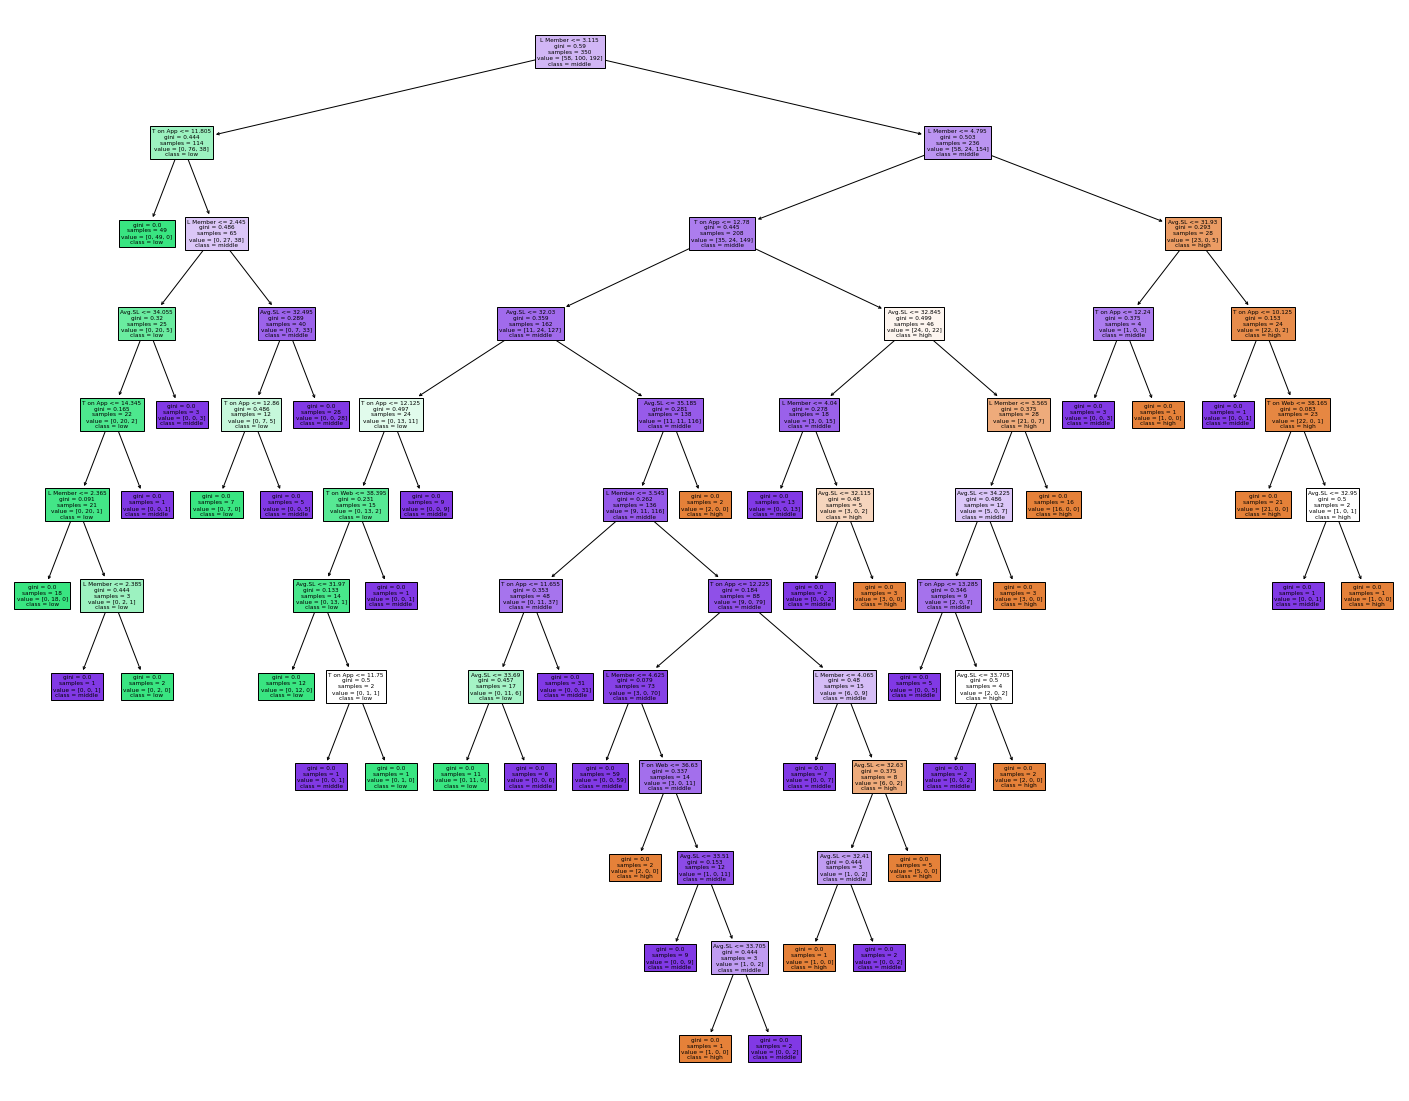

In [62]:
# Plot Tree with plot_tree
fig = plt.figure(figsize=(25,20))
Treeplot = tree.plot_tree(clf, 
                   feature_names=['Avg.SL', 'T on App', 'T on Web', 'L Member'],  
                   class_names=['high', 'low', 'middle'],
                   filled=True)

In [ ]:
# since the tree is so big, try to use max depth =4 and test the accuracy

In [30]:
clf = DecisionTreeClassifier(random_state=1234,max_depth=4)
model = clf.fit(X_train3, y_train3)
text_representation = tree.export_text(clf)
yp_train3 = model.predict(X_train3)
y_pred3=model.predict(X_test3)

In [35]:
print('---------------- train Result ------------------')
print(classification_report(y_train3, yp_train3))
print('Accuracy score:',accuracy_score(y_train3,yp_train3))

---------------- train Result ------------------
              precision    recall  f1-score   support

        high       0.85      0.76      0.80        58
         low       0.83      0.89      0.86       100
      middle       0.87      0.86      0.87       192

    accuracy                           0.85       350
   macro avg       0.85      0.84      0.84       350
weighted avg       0.85      0.85      0.85       350

Accuracy score: 0.8542857142857143


In [36]:
print('---------------- test Result ------------------')
print(classification_report(y_test3, y_pred3))
from sklearn.metrics import accuracy_score
print('Accuracy score:',accuracy_score(y_test3,y_pred3))
print(confusion_matrix(y_test3, y_pred3))

---------------- test Result ------------------
              precision    recall  f1-score   support

        high       0.81      0.67      0.73        33
         low       0.72      0.80      0.76        35
      middle       0.79      0.80      0.80        82

    accuracy                           0.77       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.78      0.77      0.77       150

Accuracy score: 0.7733333333333333
[[22  0 11]
 [ 0 28  7]
 [ 5 11 66]]


In [24]:
cm3=confusion_matrix(y_test3, y_pred3)

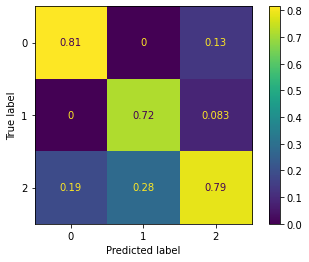

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(confusion_matrix=cm3/cm3.sum(axis=0))
disp.plot()

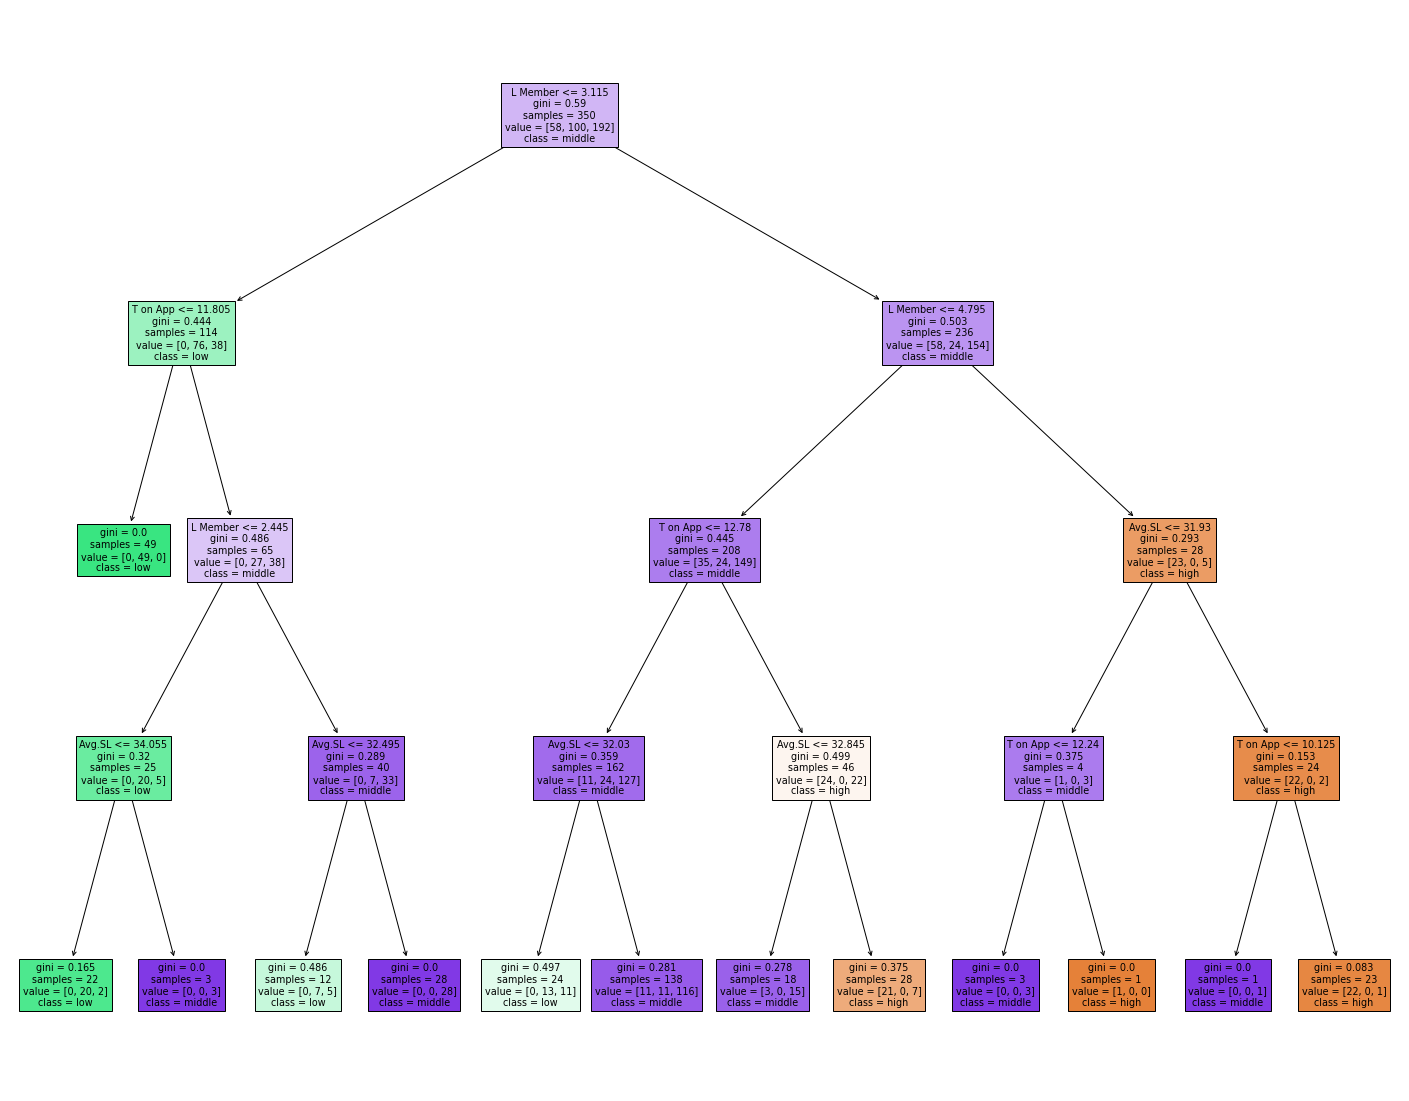

In [17]:
fig = plt.figure(figsize=(25,20))
Treeplot = tree.plot_tree(clf, 
                   feature_names=['Avg.SL', 'T on App', 'T on Web', 'L Member'],  
                   class_names=['high', 'low', 'middle'],
                   filled=True)

In [ ]:
# we can see that half of the gini coefficient of those last tree nodes finally became 0, which means they are pure.
# And most of them are very closely to 0, so the tree generally performs pretty well. Also the tree with max depth=4 looks much more clean than without seting the depth.

In [119]:
# fig.savefig("./images/Decision_tree/DT3.png")

In [49]:
# add a column spent_cat which depends on the element of the column Yealy Spent. Convert into integer.
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# df3_use['spent_cat'] = labelencoder.fit_transform(df3_use['Yearly Spent'])
X_trans= np.array(df3_use[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']].values.tolist())
y_trans=np.array(labelencoder.fit_transform(df3_use['Yearly Spent']))

In [ ]:
from dtreeviz.trees import dtreeviz 

viz = dtreeviz(clf, X_train3, y_trans,
                target_name="yearly spent",
                feature_names=['Avg.SL', 'T on App', 'T on Web', 'L Member'],
                class_names=['high', 'low', 'middle'])

viz

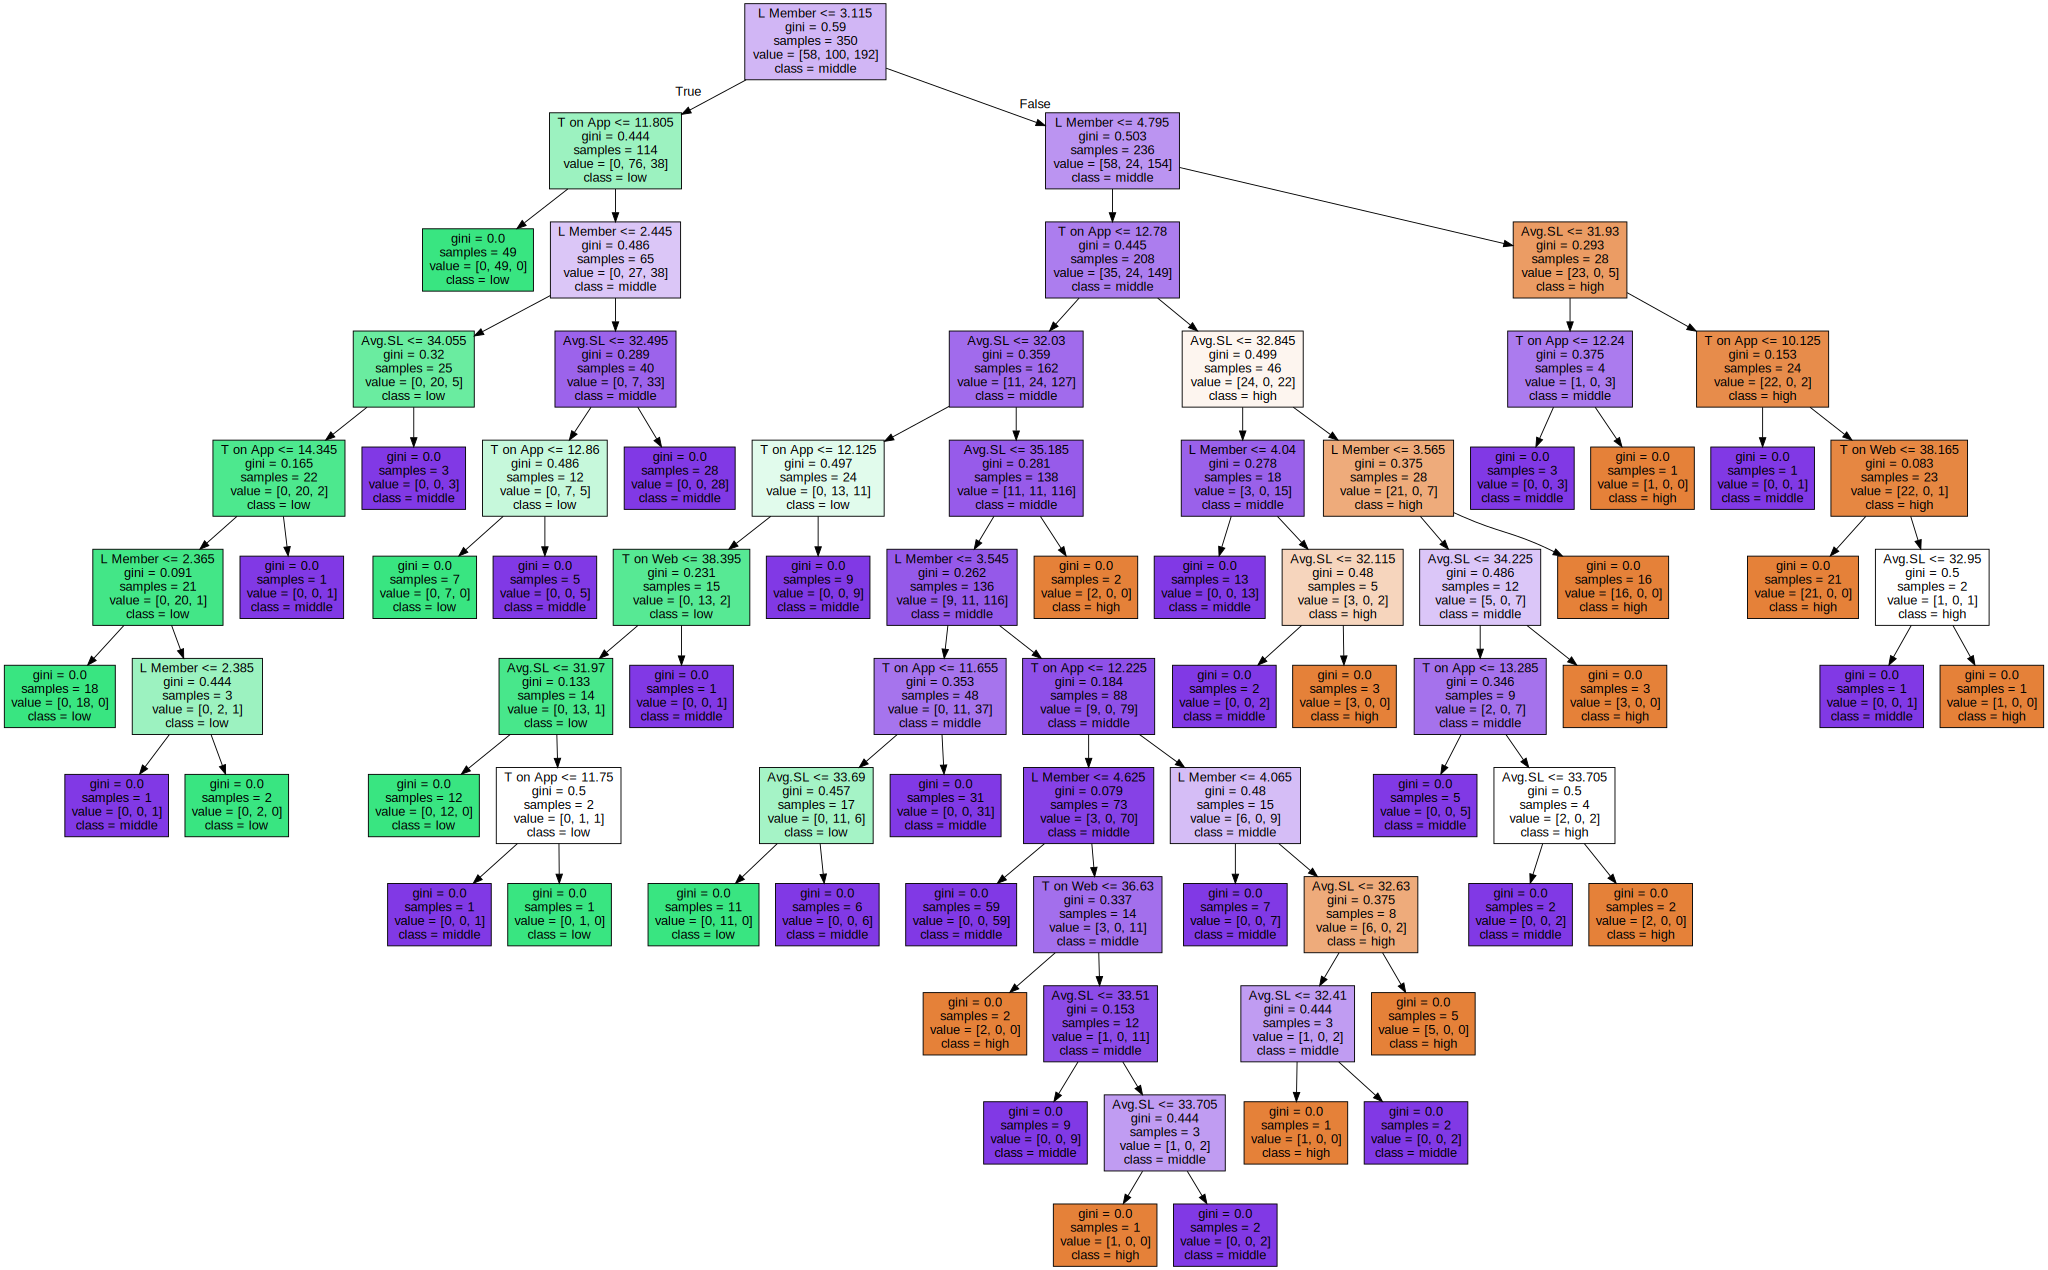

In [43]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=['Avg.SL', 'T on App', 'T on Web', 'L Member'],  
                                class_names=['high', 'low', 'middle'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [50]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_trans=labelencoder.fit_transform(y_train3)
y_test_trans=labelencoder.fit_transform(y_test3)

In [51]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
regr = DecisionTreeRegressor(max_depth=3, random_state=1234)
# model = regr.fit(X, y)
# model = regr.fit(X, y_trans)
model = regr.fit(X_train3, y_trans)
y_pred3=model.predict(X_test3)

In [52]:
y_pred_trans=labelencoder.fit_transform(y_pred3)

In [ ]:
# DecisionTreeRegressor is not suitable for my research, since it's used to solve regression.
# But I will make sure first by checking the accuracy

In [53]:
print(classification_report(y_test_trans, y_pred_trans))
from sklearn.metrics import accuracy_score
print('Accuracy score:',accuracy_score(y_test_trans, y_pred_trans))
print(confusion_matrix(y_test_trans, y_pred_trans))

              precision    recall  f1-score   support

           0       0.75      0.09      0.16        33
           1       0.00      0.00      0.00        35
           2       0.12      0.04      0.06        82
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.04       150
   macro avg       0.15      0.02      0.04       150
weighted avg       0.23      0.04      0.07       150

Accuracy score: 0.04
[[ 3 12  0  3 15  0]
 [ 0  0 21  0 14  0]
 [ 1  3  3  7 66  2]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [ ]:
# By checking the result, we can clearly see that this model is not suitable for my research.

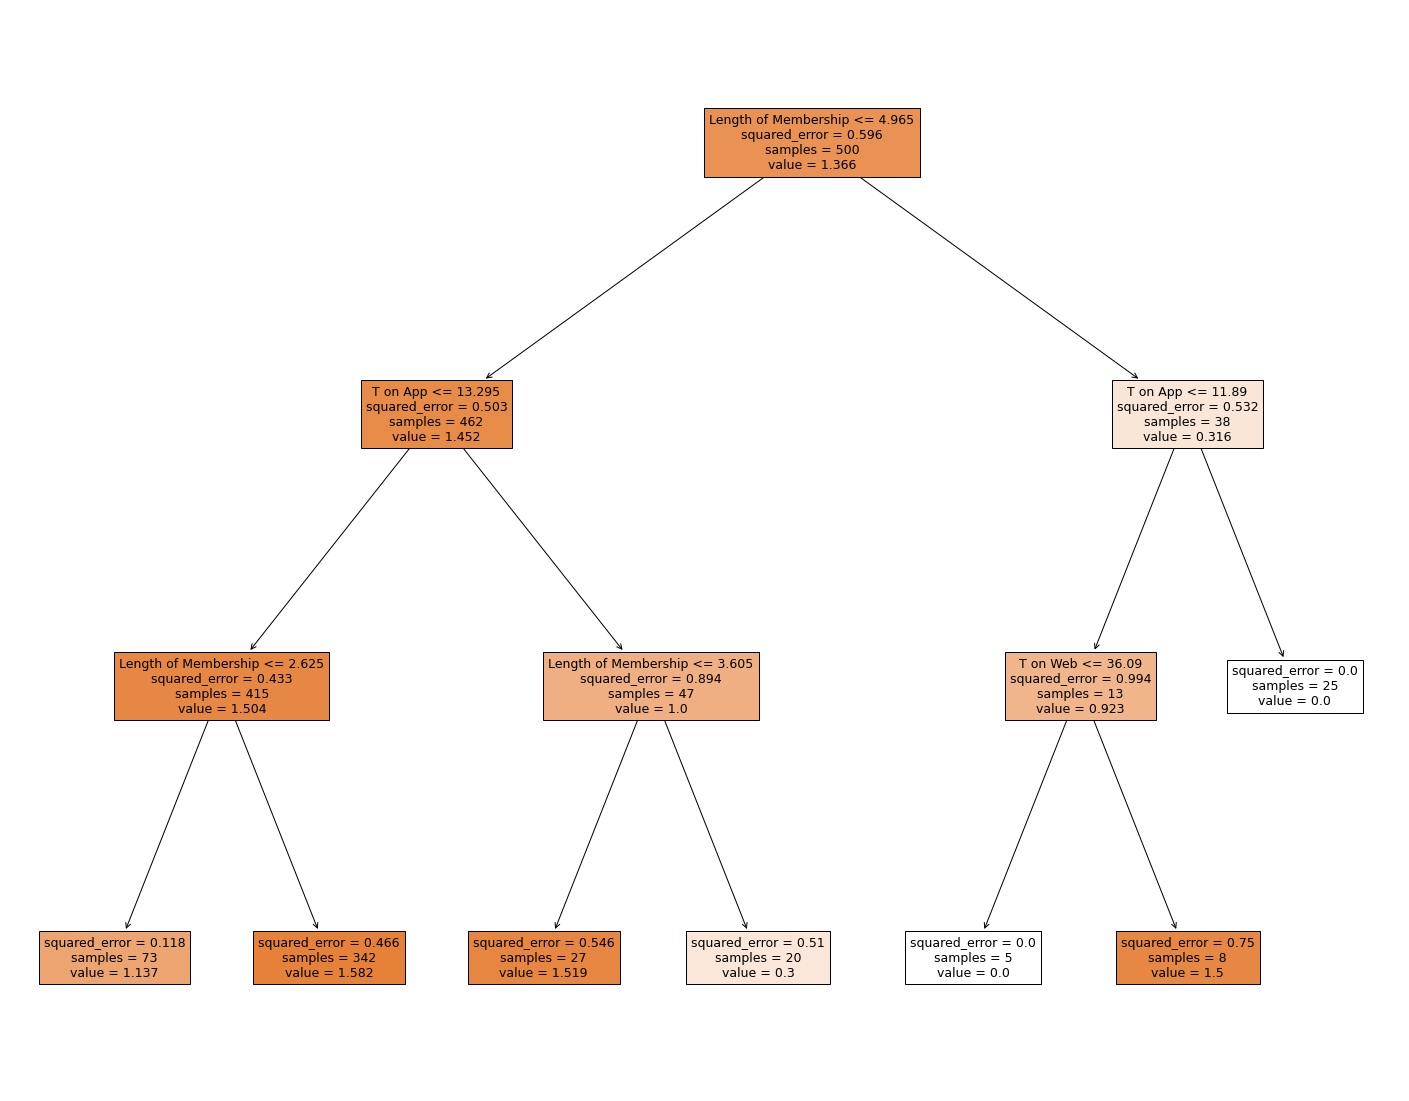

In [153]:
fig = plt.figure(figsize=(25,20))
RegTree = tree.plot_tree(regr, feature_names=['Avg.Session Length', 'T on App', 'T on Web', 'Length of Membership'], filled=True)